In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from skimage import color, morphology, filters


# measurement parameters
# quad name in bmad QM10651, PV QUAD:IN10:651:BCTRL
# quad length 1.08e-1 m
# quad location 16.414943 m

# screen PV PROF:LI11:375
# PR11375[alias]=OTRS:LI11:375
# location 50.553112

folder = "D:/SLAC/FACET-II/emittance_scan/images/PR11375/"

tkwargs = {"device":"cuda", "dtype": torch.float32}


## Image processing

In [2]:
raw_images = []
n_samples = 5
for i in range(1, 11):
    for j in range(n_samples):
        fname = folder + f"PR11375_data_step{i:0>2}_{j:0>4}.tif"
        im = Image.open(fname)
        raw_images += [np.array(im)[600:800, 400:600]]


# apply filters to images
def apply_filter(image):
    return filters.median(image, morphology.disk(2))

thresh = filters.threshold_triangle(apply_filter(raw_images[-1]))

max_val = np.max(np.array(raw_images))

images = []
for im in raw_images:
    # apply median filter
    im = apply_filter(im)

    im = np.where(im > thresh, im, 0)
    images += [im]

images = np.array(images)

# create meshgrid for images
xx = np.meshgrid(
    np.arange(images[0].shape[0]),
    np.arange(images[0].shape[1]),
)

plt.figure()

# find centroid and rms size of images to center and crop
cx = np.average(xx[0], weights=images.sum(axis=0))
cy = np.average(xx[1], weights=images.sum(axis=0))
std_x = np.sqrt(np.average((xx[0] - cx)**2, weights=images.sum(axis=0)))
std_y = np.sqrt(np.average((xx[1] - cy)**2, weights=images.sum(axis=0)))
print(std_x, std_y)

cx = int(cx)
cy = int(cy)

# crop pixels
std = int(max(std_y,std_x))
margin = 3
bounds_x = slice(*[cx - margin*std, cx + margin*std])
bounds_y = slice(*[cy - margin*std, cy + margin*std])
xx[0] = xx[0][bounds_x, bounds_y] - cx
xx[1] = xx[1][bounds_x, bounds_y] - cy
images = images[:, bounds_x, bounds_y]

# pixel scaling
xx = np.asfarray(xx) * 8.97*1e-6
xx = xx * 10.0

# convert image data to tensors
# scale images such that the sum is 1
all_images = torch.tensor(np.array(images, dtype=int), **tkwargs)
all_images = all_images / all_images.sum(dim=-1).sum(dim=-1).unsqueeze(1).unsqueeze(1)

# grab subset of images for training
train_images = all_images[5:]

22.278849657359288 13.021215495380213


<Figure size 432x288 with 0 Axes>

## create training beamlines

In [3]:
from track import Particle, Quadrupole, Drift, Lattice
k_in = torch.linspace(-10, 20, 10, **tkwargs)
k_in = torch.vstack([k_in.unsqueeze(0) for _ in range(5)]).T.flatten().unsqueeze(1)
train_k = k_in[5:]
print(train_k)

quad = Quadrupole(torch.tensor(0.1, **tkwargs), K1=train_k)
drift = Drift(L=torch.tensor(1.0, **tkwargs))
train_lattice = Lattice([quad, drift], torch)

quad = Quadrupole(torch.tensor(0.1, **tkwargs), K1=k_in)
drift = Drift(L=torch.tensor(1.0, **tkwargs))
all_lattice = Lattice([quad, drift], torch)



tensor([[-6.6667e+00],
        [-6.6667e+00],
        [-6.6667e+00],
        [-6.6667e+00],
        [-6.6667e+00],
        [-3.3333e+00],
        [-3.3333e+00],
        [-3.3333e+00],
        [-3.3333e+00],
        [-3.3333e+00],
        [-2.3842e-07],
        [-2.3842e-07],
        [-2.3842e-07],
        [-2.3842e-07],
        [-2.3842e-07],
        [ 3.3333e+00],
        [ 3.3333e+00],
        [ 3.3333e+00],
        [ 3.3333e+00],
        [ 3.3333e+00],
        [ 6.6667e+00],
        [ 6.6667e+00],
        [ 6.6667e+00],
        [ 6.6667e+00],
        [ 6.6667e+00],
        [ 1.0000e+01],
        [ 1.0000e+01],
        [ 1.0000e+01],
        [ 1.0000e+01],
        [ 1.0000e+01],
        [ 1.3333e+01],
        [ 1.3333e+01],
        [ 1.3333e+01],
        [ 1.3333e+01],
        [ 1.3333e+01],
        [ 1.6667e+01],
        [ 1.6667e+01],
        [ 1.6667e+01],
        [ 1.6667e+01],
        [ 1.6667e+01],
        [ 2.0000e+01],
        [ 2.0000e+01],
        [ 2.0000e+01],
        [ 2

## set up model ensemble

In [4]:
from modeling import ImagingModel, NonparametricTransform
from copy import deepcopy
import time
defaults = {
    "s": torch.tensor(0.0, **tkwargs),
    "p0c": torch.tensor(1.0, **tkwargs),
    "mc2": torch.tensor(1.0, **tkwargs),
}

xxt = torch.tensor(xx, **tkwargs)
bins = xxt[0][0]
bandwidth = torch.tensor(1e-4, **tkwargs)
n_particles = 10000

transform = NonparametricTransform()
transform.to(tkwargs["device"])

models = []
n_models = 5
for _ in range(n_models):
    models += [
        deepcopy(
            ImagingModel(
                transform,
                bins,
                bandwidth,
                torch.tensor(n_particles),
                defaults
            )
        )
    ]

# convert to a ModuleList, set dtype and send to GPU
models = torch.nn.ModuleList(models)
models.float()
models.cuda();



## train

100%|██████████| 4000/4000 [03:30<00:00, 18.98it/s]


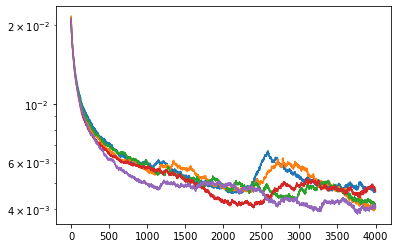

In [5]:
from modeling import train
from tqdm import trange

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.uniform_(m.weight, -1.0, 1.0)

fig, ax = plt.subplots()
for i in range(n_models):
    # apply weird initialization
    models[i].apply(init_weights)

    losses = train(models[i], train_lattice, train_images, 4000)
    ax.semilogy(losses)

# after training send models to cpu and clear gpu cache
models.cpu()
torch.cuda.empty_cache()


## visualize mean and uncertainty of beam subspaces

C:\Users\Ryan Roussel\AppData\Local\Temp\ipykernel_19796\1231315717.py:34: RuntimeWarning: invalid value encountered in true_divide
  c = ax[2].pcolor(*xx*5, stds / means)


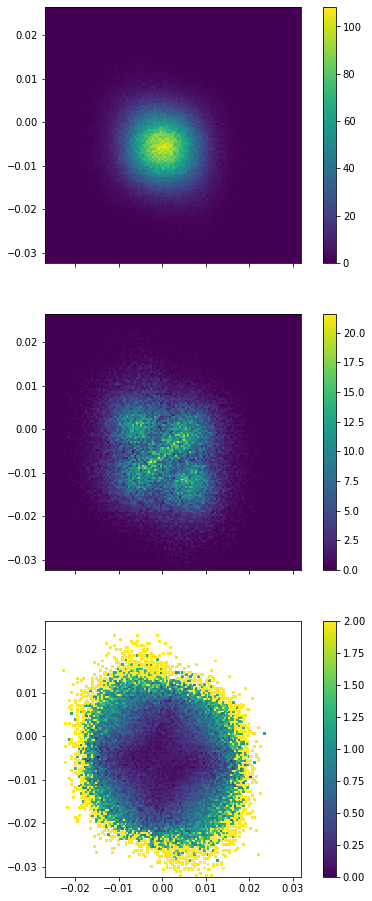

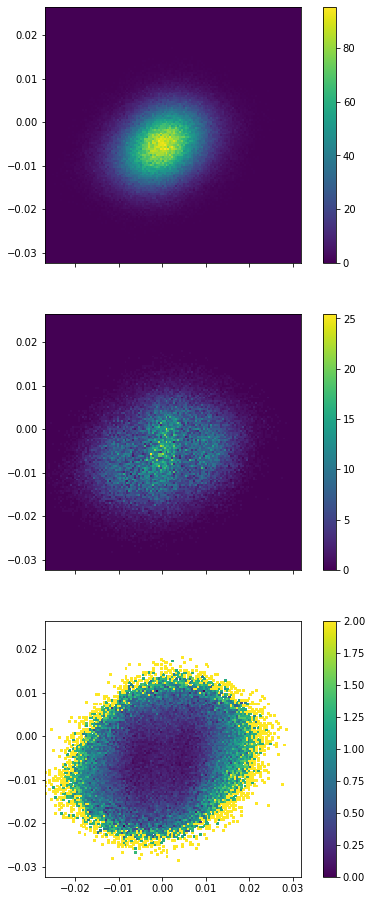

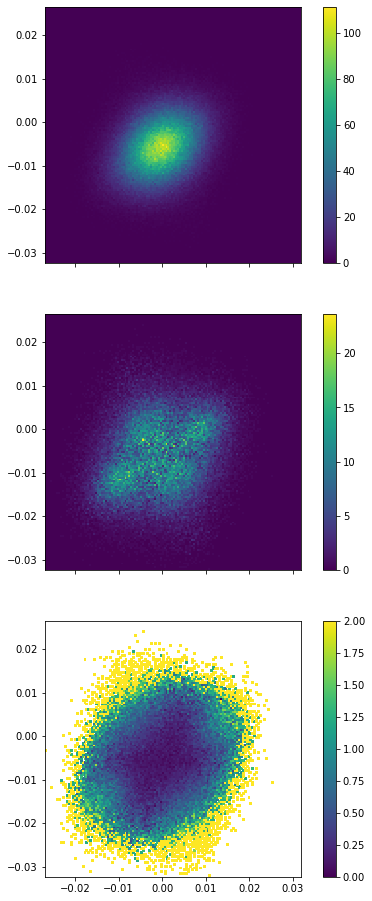

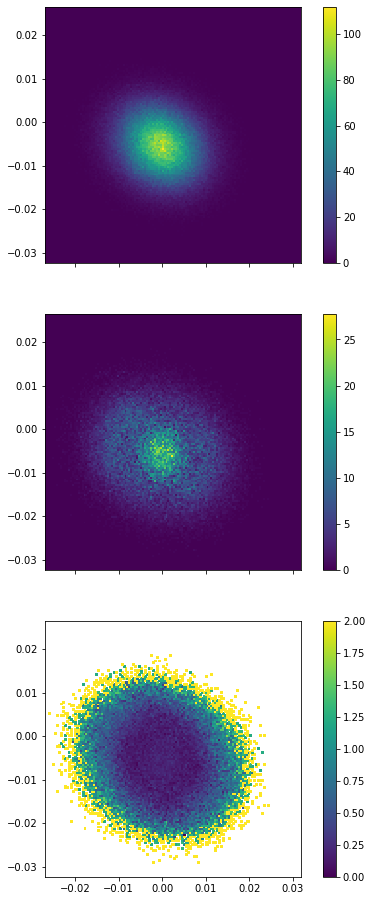

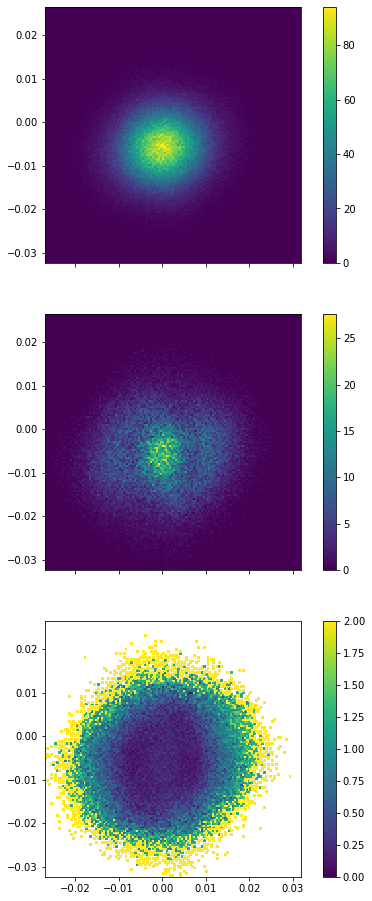

In [9]:
dims = ["x", "y"]

def plot_phase_space(x, y, ms):
    # calculate histograms
    histograms = []
    for ele in ms:
        initial_beam = ele.get_initial_beam(100000)
        histograms += [np.histogram2d(
            getattr(initial_beam, x).cpu().detach().numpy(),
            getattr(initial_beam, y).cpu().detach().numpy(),
            bins = [ele.bins.cpu().numpy()*5]*2
        )[0]]

        del initial_beam
        torch.cuda.empty_cache()

    # calculate mean and std of histograms
    histograms = np.asfarray(histograms)

    means = np.mean(histograms, axis=0)
    stds = np.std(histograms, axis=0)

    fig, ax = plt.subplots(3,1,sharex="all",sharey="all")
    fig.set_size_inches(8,16)
    for a in ax:
        a.set_aspect("equal")

    c = ax[0].pcolor(*xx*5, means)
    fig.colorbar(c, ax=ax[0])
    c = ax[1].pcolor(*xx*5, stds)
    fig.colorbar(c, ax=ax[1])

    # fractional error
    c = ax[2].pcolor(*xx*5, stds / means)
    fig.colorbar(c, ax=ax[2])

plot_phase_space("x","y",models)
plot_phase_space("y","py",models)
plot_phase_space("x","px",models)
plot_phase_space("y","px", models)
plot_phase_space("x","py", models)


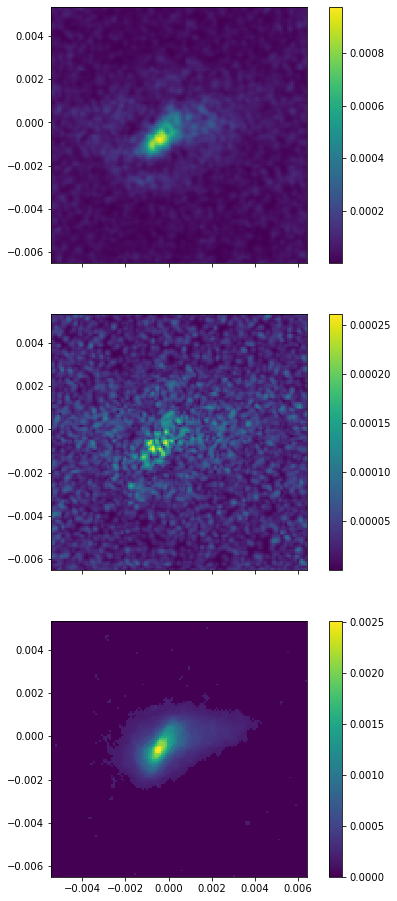

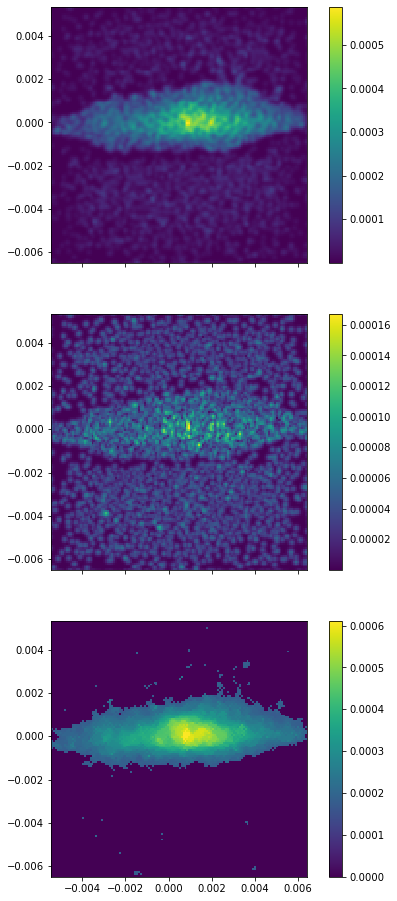

In [7]:
quad = Quadrupole(torch.tensor(0.1), K1=k_in.to("cpu"))
drift = Drift(L=torch.tensor(1.0))
all_lattice = Lattice([quad, drift], torch)

def plot_images(ms, lattice, im_number):
    # calculate histograms
    output_images = []
    for ele in ms:
        output_images += [ele(lattice).unsqueeze(0)]

    # calculate mean and std of histograms
    output_images = torch.cat(output_images).detach().numpy()

    means = np.mean(output_images, axis=0)
    stds = np.std(output_images, axis=0)

    fig, ax = plt.subplots(3,1,sharex="all",sharey="all")
    fig.set_size_inches(8,16)
    for a in ax:
        a.set_aspect("equal")

    c = ax[0].pcolor(*xx, means[im_number])
    fig.colorbar(c, ax=ax[0])
    c = ax[1].pcolor(*xx, stds[im_number])
    fig.colorbar(c, ax=ax[1])

    c = ax[2].pcolor(*xx, all_images[im_number].cpu())
    fig.colorbar(c, ax=ax[2])


plot_images(models, all_lattice, 1)
plot_images(models, all_lattice, -1)
